# PROJET MALAP

***A Continuation Method for Semi-Supervised SVMs***

*AKROUCH Marwan* et *NEDERVEEN Cyril*

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'MALAP_TP_1'
  %cd /content/gdrive/My\ Drive/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/MALAP_TP_1


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import random
from scipy.special import erf
from pylab import *

For this project, we will use the [MNIST dataset (~15Mo)](https://educnet.enpc.fr/mod/resource/view.php?id=44975). It consists of 28x28 images (loaded as a 784 vector) and the associated label for training, validation and test sets. 

The following code loads all samples from the MNIST archive into several arrays, then displays the first sample from the training set as an image. We will limit ourselves to the first 1000 samples of train and 1000 samples of validation.

5


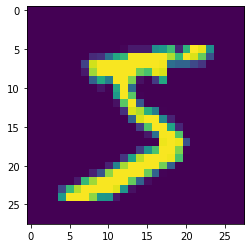

In [ ]:
# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, val_set, test_set = pickle.load(f, encoding='latin1') # python 3
# train_set, val_set, test_set = cPickle.load(f) # python 2
f.close()
N = 1000
train_data=train_set[0][0:N, :]
train_labels=train_set[1][0:N]
val_data=val_set[0][0:N, :]
val_labels=val_set[1][0:N]
N_train=train_data.shape[0]
N_val=val_data.shape[0]
# check data makes sense
plt.imshow(train_data[0,:].reshape(28,28))
print(train_labels[0])

Here, we define the 0-1 loss that measures the error rate of a classifier.

In [ ]:
def error_rate(y_hat, y):
    return (1.-(y_hat==y)).mean()

***Convolved loss*** \\

$L_{\gamma}(\textbf{w}) = \frac{1}{2}\textbf{w}^\top\textbf{w} + \frac{1}{2}\gamma d +  C \sum_{i=1}^n \frac{\gamma \| \textbf{x}_i\|}{\sqrt{2}}\left[ \frac{\text{exp}(-e_i^2)}{\sqrt{\pi}}-e_i \text{erfc}(e_i) \right] + C^* \sum_{i=n+1}^{n+m} \frac{1}{\sqrt{a_i}}\text{exp}\left( \frac{-s(\textbf{w}^\top \textbf{x}_i + b)^2}{a_i} \right)$

such that $a_i = 1 + 2\gamma s \|\textbf{x}_i\|^2$  ,  $e_i = \frac{y_i(\textbf{w}^\top \textbf{x}_i + b) - 1}{\sqrt{2\gamma}\| \textbf{x}_i \|}$   and  erfc$(x) = \frac{2}{\sqrt{\pi}}\int_x^\infty e^{-t^2}dt $

the gradient at w is given by: \\
$\nabla L_{\gamma}(\textbf{w}) = \textbf{w}^\top +  \frac{C}{2} \sum_{i=1}^n \text{erfc}(e_i)y_i \textbf{x}_i^\top - C^* \sum_{i=n+1}^{n+m} \frac{2s(\textbf{w}^\top \textbf{x}_i + b)}{a_i^{3/2}}\text{exp}\left( \frac{-s(\textbf{w}^\top \textbf{x}_i + b)^2}{a_i} \right)\textbf{x}_i^\top$

In [ ]:
class convolvedLoss:
    def __init__(self, gamma, C = 1, C_etoile = 1, s=3):
        """ 
        paramaters : 
        gamma : parameter of the gaussian in the convolution (stdv)
        C : box parameter for labeled data (large C => smaller margin)
        C_etoile : box parameter for unlabeled data
        s : parameter of the loss l: t -> exp(-st^2) 
        """
        self.gamma = gamma
        self.C = C
        self.C_etoile = C_etoile
        self.s = s

    def __call__(self, X_lab, X_unlab, y_lab, w, b):
        """
        Parameters
        ----------
        X_lab : labeled data
        X_unlab : unlabeled data
        y_lab : labels of labeled data
        w : weights
        b : bias
        Returns
        -------
        value of L_gamma at w
        """
        d = len(w)
        a_lab = 1 + 2*self.gamma*self.s*jnp.linalg.norm(X_lab, ord=2, axis=1)**2
        a_unlab = 1 + 2*self.gamma*self.s*jnp.linalg.norm(X_unlab, ord=2, axis=1)**2
        e = (y_lab*(jnp.matmul(X_lab,w.T)+b)-1)/(jnp.sqrt(2*self.gamma)*jnp.linalg.norm(X_lab, ord=2, axis=1))
        
        term1 = 1/2 * jnp.matmul(w,w.T) + 1/2*self.gamma*d
        term2 = self.C*self.gamma/jnp.sqrt(2)*(jnp.linalg.norm(X_lab, ord=2, axis=1)*(np.exp(-e**2/jnp.sqrt(jnp.pi)-e*(1-erf(e))))).sum()
        term3 = self.C_etoile*(1/jnp.sqrt(a_unlab)*jnp.exp(-self.s*(jnp.matmul(X_unlab,w.T)+b)**2/a_unlab)).sum()

        return term1 + term2 + term3

    def grad_w(self, X_lab, X_unlab, y_lab, w, b):
        """
        gradient of L_gamma w.r.t weights
        Parameters
        ----------
        X_lab : labeled data
        X_unlab : unlabeled data
        y_lab : labels of labeled data
        w : weights
        b : bias
        Returns
        -------
        value of grad of L_gamma at w
        """
        e = (y_lab*(jnp.matmul(X_lab,w.T)+b)-1)/(jnp.sqrt(2*self.gamma)*jnp.linalg.norm(X_lab, ord=2, axis=1))
        a_unlab = 1 + 2*self.gamma*self.s*jnp.linalg.norm(X_unlab, ord=2, axis=1)**2
        return w - self.C/2 * ((1-erf(e))*y_lab*X_lab.T).sum(axis=1) - self.C_etoile * (2*self.s*(jnp.matmul(X_unlab,w.T)+b)/jnp.sqrt(a_unlab**3)*jnp.exp(-self.s*(jnp.matmul(X_unlab,w.T)+b)**2/a_unlab)*X_unlab.T).sum(axis=1)

    def w_optimize(self, w0, b, X_lab, X_unlab, y_lab, lr=0.1, eps = 1e-2, max_iter = 5):
        """
        gradient descent steps
        Parameters
        ----------
        w0 : weights
        b : bias
        X_lab : labeled data
        X_unlab : unlabeled data
        y_lab : labels of labeled data
        lr : learning rate
        eps : stop when gradient is close to 0
        max_iter : max number of descent steps
        Returns
        -------
        value of grad of L_gamma at w
        """
        w = w0
        direction = self.grad_w(X_lab,X_unlab,y_lab,w,b)
        counter = 0
        while(jnp.linalg.norm(direction)>eps and counter < max_iter) :
            w = w - lr*direction
            direction = self.grad_w(X_lab,X_unlab,y_lab,w,b)
            counter +=1
        return w

***S3VM two classes classification***

bellow is a class for a two class classification S3VM. \

In order not to end up in the situation where the non-labeled data is only "stored" on one side, we assume:
$\frac{1}{m}\sum_{i=n+1}^m \textbf{w}^\top \textbf{x}_i + b  = \frac{1}{n}\sum_{i=1}^n y_i$.
So, by centering the labeled data and fixing $\frac{1}{n}\sum_{i=1}^n y_i$, we solve two difficulties at once because on the one hand, it is no longer necessary to optimize under constraints and on the other hand there is only $ \textbf{w}$ as variable. this is what the method _initialize_weights_bias does.

the gamma_values method calculates $\gamma_0$ and $\gamma_{end}$

$
\gamma_0 = \frac{(C^*\lambda_{max})^{2/3}}{(2s)^{1/3}} \quad \text{et} \quad \gamma_{end} = \frac{1}{10}\frac{1}{2s \text{max}_i \| x_i \|^2}
$

where $\lambda_{max}$ is the largest eigen value of the matrix $ M =\sum_{i = n+1}^{n+m}\frac{\textbf{x}_i \textbf{x}_i^\top}{\| \textbf{x}_i \|^3}$. the sequence is of size = 10 and decreaces exponentially :

$
\gamma_i = \left( \frac{\gamma_{end}}{\gamma_0} \right)^{\frac{i}{10}} \gamma_0, \quad 0 \leq i \leq 10.
$

The other methods are described in the code.

In [ ]:
class binary_S3VM:
    def __init__(self, X_lab, X_unlab, y_lab, Kernel=None, C=100., C_etoile=100., s=3, grad_max_iter=5, lr=.1, num_gammas=10, red_dim=True):
        """
        X_lab : labeled data
        X_unlab : unlabeled data
        y_lab : labels of labeled data
        Kernel : kernel
        C : box parameter for labeled data (large C => smaller margin)
        C_etoile : box parameter for unlabeled data
        s : parameter of the loss l: t -> exp(-st^2)
        grad_max_iter : max number of descent steps
        lr : learning rate
        num_gammas : number of values gamma takes as it goes down from gamma_0 to gamma_end
        red_dim : if True use only labeled data to estimate projection in k-PCA (reduce dimension further to n), if False use labeled and unlabeled data to perform k-PCA (reduce dimension to n+m)
        """
        self.Kernel = Kernel
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        if Kernel != None:
            self.nX_lab = transform(X_lab, X_lab, X_unlab, self.Kernel, red_dim)
            self.nX_unlab = transform(X_unlab, X_lab, X_unlab, self.Kernel, red_dim) 
        else:
            self.nX_lab = X_lab
            self.nX_unlab = X_unlab
        self.nX_lab = self.nX_lab 
        self.nX_unlab = self.nX_unlab - self.nX_unlab.mean(axis=0)
        self.lab1 = min(y_lab)
        self.lab2 = max(y_lab)
        self.y_lab = 2*(y_lab-jnp.min(y_lab))/(jnp.max(y_lab)-jnp.min(y_lab))-1
        self.C = C
        self.C_etoile = C_etoile  
        self.s = s
        self.grad_max_iter = grad_max_iter
        self.lr = lr
        self.num_gammas = num_gammas
        self.red_dim = red_dim
        self.loss = []

    def _initialize_weights_bias(self):
        """Initialisation de w et b"""
        n_features = self.nX_lab.shape[1]
        stdv = 1/jnp.sqrt(n_features)
        self.w = uniform(-stdv, stdv, size=n_features)
        self.b = self.y_lab.mean()
  
    def continuation_method_step(self, gamma, max_iter):
        """
        perform gradient descent steps in order to minimize the convolved loss with parameter gamma w.r.t the weights 
        parameters
        -------
        gamma : parameter of convolved loss 
        max_iter: maximum number of gradient descent steps
        """
        Loss = convolvedLoss(gamma, self.C, self.C_etoile, self.s)
        self.loss.append(Loss(self.nX_lab, self.nX_unlab, self.y_lab, self.w, self.b))
        self.w = Loss.w_optimize(self.w, self.b, self.nX_lab, self.nX_unlab, self.y_lab, lr=self.lr, max_iter=self.grad_max_iter)
  
    def fit(self, plot_loss = True):
        """
        fit the model by obtaning the optimal weights, by minimizing over the convolved loss with parameter gamma
        for gamma starting at gamma_0 big and going down step by step to gamma_end close to 0
        Parameter
        --------
        plot_loss: if true plots the convolved losses at each iteration
        """
        self._initialize_weights_bias()
        gamma_0, gamma_end= self.gamma_values()
        for i in range(self.num_gammas):
           gamma = (gamma_end/gamma_0)**(i/10) * gamma_0
           self.continuation_method_step(gamma, self.grad_max_iter)
        if plot_loss:
              plt.plot(jnp.log10(jnp.array(self.loss)))
              plt.ylabel("log10(Loss)")
              #plt.axis([None, None, 0, 1e5])

    def gamma_values(self):
        """
        the interval to which belongs the parameter gamma to use in the convolved loss,
        we start by gamma = gamma_0 and go down to gamma_end
        Returns
        --------
        gamma_0 and gamma_end 
        """
        n_features = self.nX_unlab.shape[1]
        M = np.zeros((n_features,n_features))
        for i in range(self.nX_unlab.shape[0]):
            x = self.nX_unlab[i]
            M += jnp.matmul(x[:,None],x[None,:])/ (jnp.matmul(x,x))**(3/2)  
        lambd_max = jnp.max(jnp.linalg.eigvalsh(M))
        gamma_0 = (self.C_etoile*lambd_max)**(2/3)/((2*self.s)**(1/3))
        #print(f"gamma0 = {gamma_0}")
        gamma_end = 1/10*1/(2*self.s*(jnp.linalg.norm(self.nX_unlab, ord=2, axis=1)**2).max())
        #print(f"gamma_end = {gamma_end}")
        return gamma_0, gamma_end
  
    def predict(self, X, binary_return = False, score = False):
        """
        Predicts the class for each sample in X using the sign of the decision function
        Parameters
        ----------
        X : vector of samples to be labeled
        binary_return : if True the prediction labels are returned in the form {-1,1}  (used for onevsall approach)
                        if false the actual prediction labels are returned
        score : if True returns the score array (a measure of how close each sample to be labeled is to the margin) 
        Returns
        -------
        preds : predicted labels corresponding to X
        """
        if self.Kernel != None:
            X_ = transform(X,self.X_lab,self.X_unlab,self.Kernel, self.red_dim)
        else:
            X_ = X 
        decis_func = self.decision_function(X_- X_.mean(axis=0))
        preds = jnp.sign(decis_func)
        scores = np.maximum(decis_func, 0)
    
        if binary_return:
            return 1.*(preds>0) if not score else (1.*(preds>0), scores)
        else: 
            res =  self.lab2*(preds>0) + self.lab1*(preds<0)
            return res if not score else (res,scores)
 
    def decision_function(self, X):
        return jnp.matmul(X,self.w.T)+self.b

We test the performance using two classes from MNIST, you can choose any of the digits.

In [ ]:
# labels to do binary classification on
lab1 = 3
lab2 = 0

x_train_binary = train_data[jnp.logical_or(train_labels == lab1, train_labels == lab2)]
y_train_binary = train_labels[jnp.logical_or(train_labels == lab1, train_labels == lab2)]
x_val_binary = val_data[jnp.logical_or(val_labels == lab1, val_labels == lab2)]
y_val_binary = val_labels[jnp.logical_or(val_labels == lab1, val_labels == lab2)]

percent_labeled_data = .25

n = len(x_train_binary)
n_train_lab = int(percent_labeled_data*n)

key = jax.random.PRNGKey(20)
p = list(jax.random.permutation(key, n))
X_lab_bin = x_train_binary[p[0:n_train_lab], :]
y_lab_bin = y_train_binary[p[0:n_train_lab]]
X_unlab_bin = x_train_binary[p[n_train_lab:], :]

print(f"amount of labeled data = {len(X_lab_bin)}") 
print(f"amount of unlabeled data = {len(X_unlab_bin)}")

amount of labeled data = 47
amount of unlabeled data = 143


*binary classification using linear kernel (no k-PCA)* \
The plot bellow represents the variation of the loss calculated after each time we decrease gamma, since this loss is big we plotted log10(Loss)

gamma0 = 43.126014709472656
gamma_end = 9.538465383229777e-05
Accuracy binary (without kernel) on test set: 97.56%
Accuracy binary (without kernel) on unlabeled training set: 98.60%


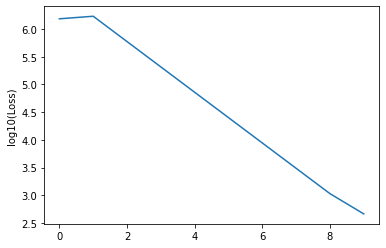

In [ ]:
# binary classification without kernel-PCA
s3vm_bin = binary_S3VM(X_lab_bin, X_unlab_bin, y_lab_bin)
s3vm_bin.fit()
pred = s3vm_bin.predict(x_val_binary)
err = error_rate(pred, y_val_binary)
print(f"Accuracy binary (without kernel) on test set: {1-err:.2%}")
pred = s3vm_bin.predict(X_unlab_bin)
y_unlab_bin = y_train_binary[p[n_train_lab:]]
err = error_rate(pred, y_unlab_bin)
print(f"Accuracy binary (without kernel) on unlabeled training set: {1-err:.2%}")

Now, we perform a cross validation to estimate the most suitable $C$ and $C^*$

In [ ]:
key = jax.random.PRNGKey(4) # chosen by a fair dice roll
def randomSplit(key, X, y, train_part=0.8, percent_lab=.25):
    n = X.shape[0]
    n_train = int(train_part*n); n_test = n - n_train
    n_train_lab = int(n_train*percent_lab); n_train_unlab = n_train - n_train_lab
    p = jax.random.permutation(key, n)
    X_train_lab = X[p[0:n_train_lab], :]; y_train_lab = y[p[0:n_train_lab]]
    X_train_unlab = X[p[n_train_lab:n_train], :]; y_train_unlab = y[p[n_train_lab:n_train]]
    X_val = X[p[n_train:],:] ; y_val = y[p[n_train:]]
    return X_train_lab, X_train_unlab, y_train_lab, y_train_unlab, X_val, y_val

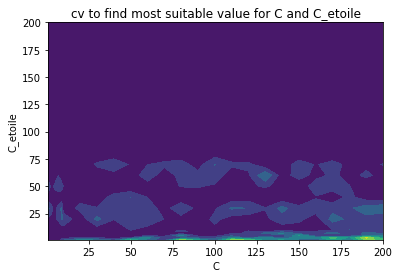

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
CC = [k for k in range(1,10,2)] + [10*k for k in range(1,21)]
CC_etoile = CC
#err_means_test = np.zeros((len(Cs),len(Cs)))
n_cv_datasets = 4

for i in range(len(CC)):
  for j in range(len(CC)):
    err_test = []
    for k in range(n_cv_datasets):
        key = jax.random.PRNGKey(k)
        X_lab, X_unlab, y_lab, y_unlab, X_val, y_val = randomSplit(key, x_train_binary, y_train_binary, .75, .25)
  
        s3vm = binary_S3VM(X_lab, X_unlab, y_lab, C=CC[i], C_etoile=CC_etoile[j])
        s3vm.fit(plot_loss = False)
        y_hat = s3vm.predict(X_val)
        err_test.append(error_rate(y_hat, y_val))
      
    # prendre la moyenne des erreurs
    err_means_test[i,j] = jnp.array(err_test).mean()
plt.contourf(CC,CC_etoile,err_means_test)
plt.xlabel("C")
plt.ylabel("C_etoile")
plt.title("cv to find most suitable value for C and C_etoile")
plt.show()

Bellow we did CV this time by assuming $C=C^*$,
Finally we chose $C=C^*=100$

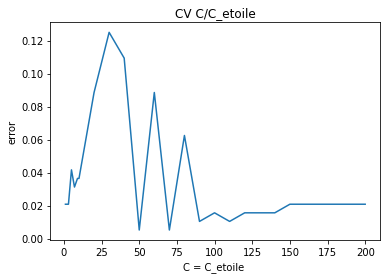

In [ ]:
# cross validation to find sigma
plt.rcParams["figure.figsize"] = (13,4)
err_means_test = []
err_means_unlab = []
C_Cetoile = [k for k in range(1,10,2)] + [10*k for k in range(1,21)]
n_cv_datasets = 4

for C in C_Cetoile:
   err_test = []
   err_unlab = []
   for i in range(n_cv_datasets):
      key = jax.random.PRNGKey(i)
      X_lab, X_unlab, y_lab, y_unlab, X_val, y_val = randomSplit(key, x_train_binary, y_train_binary, .75, .25)
 
      s3vm = binary_S3VM(X_lab, X_unlab, y_lab, C=C, C_etoile=C)
      s3vm.fit(plot_loss = False)
      y_hat = s3vm.predict(X_val)
      err_test.append(error_rate(y_hat, y_val))
      pred_unlab = s3vm.predict(X_unlab)
      err_unlab.append(error_rate(pred_unlab, y_unlab))
      
   # prendre la moyenne des erreurs
   err_means_test.append(jnp.array(err_test).mean())
   err_means_unlab.append(jnp.array(err_unlab).mean())

plt.subplot(1, 2, 1) 
plt.plot(C_Cetoile, err_means_test)
plt.xlabel("C = C_etoile ")
plt.ylabel("error")
plt.title("CV C/C_etoile")

plt.show()

Here we change the percent of labeled data in the training dataset and calculate the error after training the model. We got the plot bellow, the error w.r.t the percent of labeled data, which has a decreasing tendancy. Theoretically, as we increase the amout of labels we get better accuracy, which is shown empirically bellow. However, when the number of labeled samples is really low, we should take into account the quality of the labeled samples (diversity and ability the draw conclusions from these samples).

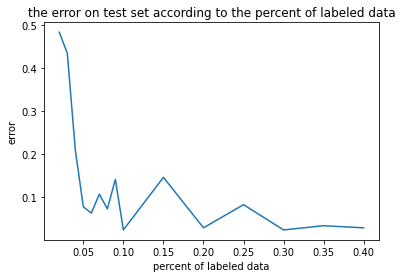

In [ ]:
percents = np.array([0.01*k for k in range(2,11)] + [0.05*k for k in range(3,9)])
err = []
for percent_labeled_data in percents:
    n = len(x_train_binary)
    n_train_lab = int(percent_labeled_data*n)
    
    key = jax.random.PRNGKey(int(percent_labeled_data*100))
    p = list(jax.random.permutation(key, n))
    X_lab_bin = x_train_binary[p[0:n_train_lab], :]
    y_lab_bin = y_train_binary[p[0:n_train_lab]]
    X_unlab_bin = x_train_binary[p[n_train_lab:], :]

    s3vm_bin = binary_S3VM(X_lab_bin, X_unlab_bin, y_lab_bin, lr=.1, grad_max_iter=5)
    s3vm_bin.fit(plot_loss=False)
    pred = s3vm_bin.predict(x_val_binary)
    error = error_rate(pred, y_val_binary) 
    err.append(error)

plt.plot(percents, err)
plt.xlabel("percent of labeled data")
plt.ylabel("error")
plt.title("the error on test set according to the percent of labeled data")
plt.show()

***Multiclass***

The approach we have adopted for a multiclass classification is One Vs All: We train $ 10 (10-1) / 2 = 45$  binary classifiers for each pair of labels, and to predict the class of an image we chose the label with the highest score. In the case of SVMs, the score is the distance to the hyperplane, i.e. the absolute value of the decision function. \
Note that we return the prediction on the unlabeled training set also.

In [ ]:
class OnevsAll_S3VM():
    def __init__(self, X_lab, X_unlab, y_lab, Kernel=None, C=100., C_etoile=100., s=3, grad_max_iter=5, num_gammas=10, red_dim=False):
        """
        X_lab : labeled data
        X_unlab : unlabeled data
        y_lab : labels of labeled data
        Kernel : kernel
        C : box parameter for labeled data (large C => smaller margin)
        C_etoile : box parameter for unlabeled data
        s : parameter of the loss l: t -> exp(-st^2)
        grad_max_iter : max number of descent steps
        red_dim : if True use only labeled data to estimate projection in k-PCA (reduce dimension further to n), if False use labeled and unlabeled data to perform k-PCA (reduce dimension to n+m)
        """
        self.Kernel = Kernel
        self.X_lab = X_lab
        self.X_unlab = X_unlab - X_unlab.mean(axis=0)
        self.y_lab = y_lab
        self.C = C
        self.C_etoile = C_etoile     
        self.s = s   
        self.grad_max_iter = grad_max_iter
        self.num_gammas = num_gammas
        self.red_dim = red_dim

    def __call__(self, x):
        """
        returns the predicted labels for the dataset x and also the predictions for the unlabeled training data
        """
        scores_test_data = []
        scores_unlab_data =[]
        for label in jnp.unique(self.y_lab):
           score_test, score_unlab = self.binary_svm(label, x)
           scores_test_data.append(score_test)
           scores_unlab_data.append(score_unlab)

        scores_test_data = jnp.array(scores_test_data).T
        scores_unlab_data = jnp.array(scores_unlab_data).T

        y_hat = jnp.argmax(scores_test_data, axis=1)
        y_unlab = jnp.argmax(scores_unlab_data, axis=1)
        return y_hat, y_unlab
        
    def binary_svm(self, label, x):
       _y = 1.*(self.y_lab == label)       
       bin_svm = binary_S3VM(self.X_lab, self.X_unlab, _y , self.Kernel, self.C, self.C_etoile, self.s, self.grad_max_iter, num_gammas = self.num_gammas, red_dim = self.red_dim)
       bin_svm.fit(plot_loss = False)
       return bin_svm.predict(x, binary_return=True, score=True)[1], bin_svm.predict(self.X_unlab, binary_return=True, score=True)[1]

*One vs All approach with linear kernel (no k-PCA)*

We got 54.10% accuracy on the test set and 62% accuracy on unlabeled training set, with 25% of data labeled. Which is pretty good.

In [ ]:
percent_labeled_data = .25

n = len(train_data)
n_train_lab = int(percent_labeled_data*n)

key = jax.random.PRNGKey(int(percent_labeled_data*100))
p = list(jax.random.permutation(key, n))
X_lab = train_data[p[0:n_train_lab], :]
y_lab = train_labels[p[0:n_train_lab]]
X_unlab = train_data[p[n_train_lab:], :]

print(f"amount of labeled data = {len(X_lab)}")
print(f"amount of unlabeled data = {len(X_unlab)}")

amount of labeled data = 250
amount of unlabeled data = 750


In [ ]:
# One vs all linear approach (no kernel)
s3vm = OnevsAll_S3VM(X_lab, X_unlab, y_lab, grad_max_iter=5, num_gammas=10)
pred_test, pred_unlab = s3vm(val_data)
err = error_rate(pred_test, val_labels)
print(f"Accuracy one vs all (10 classes) on test set: {1-err:.2%}")
err = error_rate(pred_unlab, train_labels[p[n_train_lab:]])
print(f"Accuracy one vs all (10 classes) on unlabeled train set: {1-err:.2%}")

Accuracy one vs all (10 classes) on test set: 54.10%
Accuracy one vs all (10 classes) on unlabeled train set: 62.00%


Like in the two classes case, we change the percent of labeled data in the training dataset and calculate the error after training the model. We got the plot bellow, the error w.r.t the percent of labeled data, which has a decreasing tendancy. 

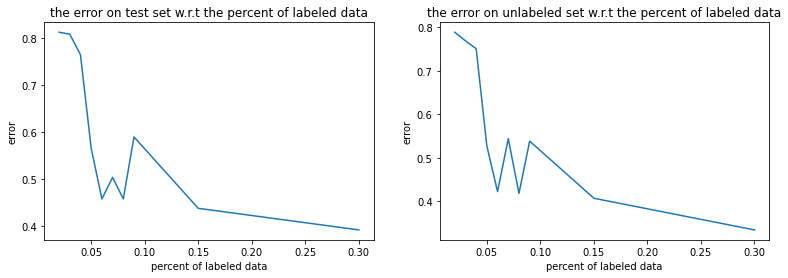

In [ ]:
plt.rcParams["figure.figsize"] = (13,4)
percents = np.array([0.01*k for k in range(2,11)] + [0.05*k for k in range(3,9)])
err_test = []
err_unlab = []

for percent_labeled_data in percents:
    n = len(train_data)
    n_train_lab = int(percent_labeled_data*n)
    
    key = jax.random.PRNGKey(int(percent_labeled_data*100))
    p = list(jax.random.permutation(key, n))
    X_lab = train_data[p[0:n_train_lab], :]
    y_lab = train_labels[p[0:n_train_lab]]
    X_unlab = train_data[p[n_train_lab:], :]

    s3vm = OnevsAll_S3VM(X_lab, X_unlab, y_lab)
    pred_test, pred_unlab = s3vm(val_data)
    error = error_rate(pred_test, val_labels) 
    err_test.append(error)
    error = error_rate(pred_unlab, train_labels[p[n_train_lab:]])
    err_unlab.append(error)

plt.subplot(1, 2, 1) 
plt.plot(percents, err_test)
plt.xlabel("percent of labeled data")
plt.ylabel("error")
plt.title("the error on test set w.r.t the percent of labeled data")

plt.subplot(1, 2, 2) 
plt.plot(percents, err_unlab)
plt.xlabel("percent of labeled data")
plt.ylabel("error")
plt.title("the error on unlabeled set w.r.t the percent of labeled data")

plt.show()

***One vs One***

We tried implementing a one vs one approach for multiclass classification, but the accuracy was less impressive.

In [ ]:
from itertools import combinations
class OnevsOne_S3VM():
    def __init__(self, X_lab, X_unlab, y_lab, Kernel=None, C=100., C_etoile=100., s=3, grad_max_iter=5):
        self.Kernel = Kernel
        self.X_lab = X_lab
        self.X_unlab = X_unlab - X_unlab.mean(axis=0)
        self.y_lab = y_lab
        self.C = C
        self.C_etoile = C_etoile     
        self.s = s   
        self.grad_max_iter = grad_max_iter
        
    def __call__(self, x):
        y_hat = -jnp.ones(x.shape[0])
        preds = jnp.zeros((x.shape[0],10))
        lab_pairs = combinations(jnp.unique(self.y_lab), 2)
        for lab1, lab2 in lab_pairs:
           pred_label = self.binary_svm(lab1, lab2, x)
           preds = jax.ops.index_add(preds, jax.ops.index[jnp.where(pred_label == 1),lab1], 1)
           preds = jax.ops.index_add(preds, jax.ops.index[jnp.where(pred_label == -1),lab2], 1)
        return jnp.argmax(preds, axis=1)
        
    def binary_svm(self, lab1, lab2, x):
       _y = 1.*(self.y_lab == lab1) + -1.*(self.y_lab == lab2)      
       bin_svm = binary_S3VM(self.X_lab, self.X_unlab, _y, self.Kernel, self.C, self.C_etoile, self.s, self.grad_max_iter)
       bin_svm.fit(plot_loss = False)
       return bin_svm.predict(x, binary_return = True)

In [ ]:
percent_labeled_data = .25

n = len(train_data)
n_train_lab = int(percent_labeled_data*n)

key = jax.random.PRNGKey(int(percent_labeled_data*100))
p = list(jax.random.permutation(key, n))
X_lab = train_data[p[0:n_train_lab], :]
y_lab = train_labels[p[0:n_train_lab]]
X_unlab = train_data[p[n_train_lab:], :]

print(f"amount of labeled data = {len(X_lab)}")
print(f"amount of unlabeled data = {len(X_unlab)}")

amount of labeled data = 250
amount of unlabeled data = 750


In [ ]:
s3vm = OnevsOne_S3VM(X_lab, X_unlab, y_lab)
pred = s3vm(val_data)
err = error_rate(pred, val_labels)
print(f"Accuracy one vs one (10 classes): {1-err:.2%}")

Accuracy one vs one (10 classes): 36.60%


***Kernel trick***

We implemented the kernel trick decribed in the section 2.3 of the paper

In [ ]:
'''
takes arguements 
x1: m x d
x2: n x d
return the Gram matrix m x n
'''
def LinearKernel(x1, x2):
    return jnp.matmul(x1, x2.T)

class GaussKernel():
    def __init__(self, sigma=1.0):
        self.sigma = sigma

    def __call__(self, x1, x2):
        return jnp.exp(-1/(2*self.sigma**2)*( jnp.linalg.norm(x1, axis=-1, keepdims=True)**2 + jnp.linalg.norm(x2, axis=-1, keepdims=True).T**2 - 2*jnp.dot(x1, x2.T)))

def transform(x, X_lab, X_unlab, Kernel, red_dim=True):  
    """
    transforme x dans l'espace H (section 2.3 of the paper)
    red_dim : if True use only labeled data to estimate projection in k-PCA (reduce dimension further to n), 
              if False use labeled and unlabeled data to perform k-PCA (reduce dimension to n+m)
    """
    n,m = len(X_lab), len(X_unlab)
    X_tot = jnp.concatenate((X_lab,X_unlab))
    K = Kernel(X_tot,X_tot)
    L, U = jnp.linalg.eigh(K)
    q = n if red_dim else n+m
    X_q = X_lab if red_dim else X_tot
    A = jnp.matmul(U , jnp.diag(jnp.sqrt(1/L)))[:q]
    return jnp.matmul(Kernel(x,X_q) , A)

*Twa classes classification with kernel Trick using RBF kernel*

For 25% labeled data, we obtained $\approx 97 \%$ accuracy on test set and $99 \%$ accuracy on unlabeled training set. This model is useful for transductive learning.

In [ ]:
# construct the data first

lab1 = 3
lab2 = 0

x_train_binary = train_data[jnp.logical_or(train_labels == lab1, train_labels == lab2)]
y_train_binary = train_labels[jnp.logical_or(train_labels == lab1, train_labels == lab2)]
x_val_binary = val_data[jnp.logical_or(val_labels == lab1, val_labels == lab2)]
y_val_binary = val_labels[jnp.logical_or(val_labels == lab1, val_labels == lab2)]

percent_labeled_data = .25

n = len(x_train_binary)
n_train_lab = int(percent_labeled_data*n)

key = jax.random.PRNGKey(5)
p = list(jax.random.permutation(key, n))
X_lab_bin = x_train_binary[p[0:n_train_lab], :]
y_lab_bin = y_train_binary[p[0:n_train_lab]]
X_unlab_bin = x_train_binary[p[n_train_lab:], :]

print(f"amount of labeled data = {len(X_lab_bin)}") 
print(f"amount of unlabeled data = {len(X_unlab_bin)}")

amount of labeled data = 47
amount of unlabeled data = 143


Bellow binary classification with kernel RBF, here we set red_dim to False, which means we use labeled and unlabeled data to perform k-PCA (reduce dimension to n+m)

Accuracy binary (Gauss kernel) on test set: 97.07%
Accuracy binary (Gauss kernel) on unlab set: 99.30%


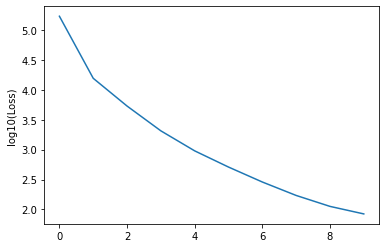

In [ ]:
# binary with kernel RBF, here we set red_dim to False which means we use labeled and unlabeled data to perform k-PCA (reduce dimension to n+m)
plt.rcParams["figure.figsize"] = (6,4)
Kernel = GaussKernel(sigma=4)
s3vm_bin = binary_S3VM(X_lab_bin, X_unlab_bin, y_lab_bin, Kernel, red_dim=False)
s3vm_bin.fit()
pred = s3vm_bin.predict(x_val_binary)
err = error_rate(pred, y_val_binary)
print(f"Accuracy binary (Gauss kernel) on test set: {1-err:.2%}")
pred = s3vm_bin.predict(X_unlab_bin)
y_unlab_bin = y_train_binary[p[n_train_lab:]]
err = error_rate(pred, y_unlab_bin)
print(f"Accuracy binary (Gauss kernel) on unlab set: {1-err:.2%}")

Bellow binary classification with kernel RBF, here we set red_dim to True, which means we use only labeled data to estimate projection in k-PCA (reduce dimension further to n)

Accuracy binary (Gauss kernel) on test set: 96.10%
Accuracy binary (Gauss kernel) on unlab set: 99.30%


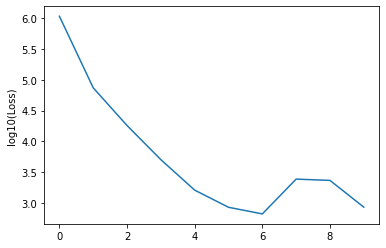

In [ ]:
# binary with kernel RBF, here we set red_dim to True, which means we use only labeled data to estimate projection in k-PCA (reduce dimension further to n)
plt.rcParams["figure.figsize"] = (6,4)
Kernel = GaussKernel(sigma=4)
s3vm_bin = binary_S3VM(X_lab_bin, X_unlab_bin, y_lab_bin, Kernel, red_dim=True)
s3vm_bin.fit()
pred = s3vm_bin.predict(x_val_binary)
err = error_rate(pred, y_val_binary)
print(f"Accuracy binary (Gauss kernel) on test set: {1-err:.2%}")
pred = s3vm_bin.predict(X_unlab_bin)
y_unlab_bin = y_train_binary[p[n_train_lab:]]
err = error_rate(pred, y_unlab_bin)
print(f"Accuracy binary (Gauss kernel) on unlab set: {1-err:.2%}")

*Multiclasses Classification with kernel Trick using RBF kernel*

In [ ]:
# construct data sets first
percent_labeled_data = .25

n = len(train_data)
n_train_lab = int(percent_labeled_data*n)

key = jax.random.PRNGKey(int(percent_labeled_data*100))
p = list(jax.random.permutation(key, n))
X_lab = train_data[p[0:n_train_lab], :]
y_lab = train_labels[p[0:n_train_lab]]
X_unlab = train_data[p[n_train_lab:], :]

print(f"amount of labeled data = {len(X_lab)}")
print(f"amount of unlabeled data = {len(X_unlab)}")

amount of labeled data = 250
amount of unlabeled data = 750


Bellow multiclass classification with kernel RBF, here we set red_dim to False, which means we use labeled and unlabeled data to perform k-PCA (reduce dimension to n+m). we took 25% labeled data, and $\sigma = 4$

In [ ]:
# One vs all with RBF kernel, red_dim = False
Kernel = GaussKernel(sigma=4)
s3vm = OnevsAll_S3VM(X_lab, X_unlab, y_lab, Kernel, red_dim=False)
pred = s3vm(val_data)
err = error_rate(pred[0], val_labels)
print(f"Accuracy one vs all (10 classes): {1-err:.2%}")

Accuracy one vs all (10 classes): 55.90%


Bellow multiclass classification with kernel RBF, here we set red_dim to True, which means we use only labeled data to estimate projection in k-PCA (reduce dimension further to n)

In [ ]:
# One vs all with RBF , red_dim = True
Kernel = GaussKernel(sigma=4)
s3vm = OnevsAll_S3VM(X_lab, X_unlab, y_lab, Kernel, red_dim=True)
pred = s3vm(val_data)
err = error_rate(pred[0], val_labels)
print(f"Accuracy one vs all (10 classes): {1-err:.2%}")

Accuracy one vs all (10 classes): 49.10%


We perform a cross validation in order to estimate the best suitable sigma parameter for RBF kernel

In [ ]:
def randomSplit(key, X, y, train_part=0.8, percent_lab=.25):
    n = X.shape[0]
    n_train = int(train_part*n); n_test = n - n_train
    n_train_lab = int(n_train*percent_lab); n_train_unlab = n_train - n_train_lab
    p = jax.random.permutation(key, n)
    X_train_lab = X[p[0:n_train_lab], :]; y_train_lab = y[p[0:n_train_lab]]
    X_train_unlab = X[p[n_train_lab:n_train], :]; y_train_unlab = y[p[n_train_lab:n_train]]
    X_val = X[p[n_train:],:] ; y_val = y[p[n_train:]]
    return X_train_lab, X_train_unlab, y_train_lab, y_train_unlab, X_val, y_val

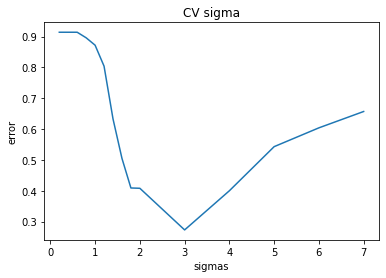

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
err_means_test = []
sigmas = [.2*k for k in range(1,10)] + list(range(2,8))
n_cv_datasets = 5

for sigma in sigmas:
   err_test = []
   for i in range(n_cv_datasets):
      key = jax.random.PRNGKey(i)
      X_lab, X_unlab, y_lab, y_unlab, X_val, y_val = randomSplit(key, train_data, train_labels, train_part=0.8, percent_lab=.25)
 
      Kernel = GaussKernel(sigma)
      s3vm = OnevsAll_S3VM(X_lab, X_unlab, y_lab, Kernel, red_dim=True)
      y_hat, _= s3vm(X_val)
      err_test.append(error_rate(y_hat, y_val))
      
   # prendre la moyenne des erreurs
   err_means_test.append(jnp.array(err_test).mean())

plt.plot(sigmas, err_means_test)
plt.xlabel("sigmas")
plt.ylabel("error")
plt.title("CV sigma")
plt.show()

We better avoid small values for $\sigma$ ! It seems a good idea to take $\sigma$ between 2 and 4, we took $3$ for the final model.

***Results*** \

We took 25% of the data as labeled as always. We used an RBF kernel with parameter $\sigma=3$ and we set red_dim to True (use only $\textbf{x}_{lab}$ for projection in k-PCA) so that we reduce the complexity of the model. 

In [ ]:
# construct data sets
percent_labeled_data = .25

n = len(train_data)
n_train_lab = int(percent_labeled_data*n)

key = jax.random.PRNGKey(int(percent_labeled_data*100))
p = list(jax.random.permutation(key, n))
X_lab = train_data[p[0:n_train_lab], :]
y_lab = train_labels[p[0:n_train_lab]]
X_unlab = train_data[p[n_train_lab:], :]

print(f"amount of labeled data = {len(X_lab)}")
print(f"amount of unlabeled data = {len(X_unlab)}")

amount of labeled data = 250
amount of unlabeled data = 750


In [ ]:
# One vs all with RBF , red_dim = True
Kernel = GaussKernel(sigma=3)
s3vm = OnevsAll_S3VM(X_lab, X_unlab, y_lab, Kernel, red_dim=True)
pred = s3vm(val_data)
err = error_rate(pred[0], val_labels)
print(f"Accuracy one vs all (10 classes): {1-err:.2%}")

Accuracy one vs all (10 classes): 68.70%


$68.7\%$ is the accuracy on the test set. 